In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, minmax_scale
from scipy.stats import pearsonr, spearmanr, f_oneway, norm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import scanpy as sc
import torch
import torch.nn as nn
torch.cuda.set_device(0)
import re
from sklearn.preprocessing import FunctionTransformer

from CauTrigger.utils import set_seed, select_features
from CauTrigger.model import CauTrigger1L, CauTrigger2L

In [2]:
data_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/CaseAxis/data/'
output_dir = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/CaseAxis/output/'
os.makedirs(output_dir, exist_ok=True)

In [3]:
microb_df = pd.read_csv(os.path.join(data_dir, '16sRNA.csv'), index_col=0).fillna(0)

In [4]:
microb_df = microb_df.iloc[np.where(np.sum(microb_df.T != 0) >= 6)[0], :]
microb = minmax_scale(microb_df)
microb_df.iloc[:] = microb

In [5]:
prot = pd.read_csv(os.path.join(data_dir, 'host_Proteomics.csv'), index_col=0)

In [6]:
def reorder_column_name(col):
    match = re.match(r"(\d+)([A-Z])", col)
    if match:
        return match.group(2) + match.group(1)
    else:
        return col

prot.columns = [reorder_column_name(col) for col in prot.columns]


def sort_key(col):
    match = re.match(r"([A-Z])(\d+)", col)
    if match:
        return (match.group(1), int(match.group(2)))
    return (col, 0)


sorted_columns = sorted(prot.columns, key=sort_key)
prot = prot[sorted_columns]
labels = prot.loc['Label']
prot_df = prot.iloc[1:]
prot = minmax_scale(prot_df)
prot_df.iloc[:] = prot

In [7]:
set_seed(42)

In [8]:
df = prot.T
df = pd.DataFrame(df, columns=prot_df.index, index=prot_df.columns)
df = df.astype(float)

In [ ]:
set_seed(42)

In [10]:
adata_layer1 = sc.AnnData(X=np.array(prot, dtype=np.float32).T)
adata_layer1.obs_names = prot_df.columns
adata_layer1.var_names = prot_df.index
adata_layer1.obs['labels_ori'] = labels.values
adata_layer1.obs['labels'] = labels.apply(lambda tg: 1 if tg == labels[0] else 0)

model_1L = CauTrigger1L(
    adata_layer1,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=False,
    init_weight=None,
    init_thresh=0.0,
    attention=False,
    att_mean=False,
)
model_1L.train(max_epochs=300, stage_training=True)
df_layer1, _ = model_1L.get_up_feature_weights(method='SHAP', sort_by_weight=False)

training: 100%|██████████| 300/300 [00:19<00:00, 15.17it/s]


In [12]:
topk_indices = df_layer1["weight"].values.argsort()[-100:]
X_down = adata_layer1[:, topk_indices]

adata_layer2 = sc.AnnData(
    X=microb.T,
    obsm={"X_down": X_down.X.toarray()}
)
adata_layer2.obs_names = microb_df.columns
adata_layer2.var_names = microb_df.index
adata_layer2.obs['labels_ori'] = labels.values
adata_layer2.obs['labels'] = labels.apply(lambda tg: 1 if tg == labels[0] else 0)

model_2L = CauTrigger2L(
    adata_layer2,
    n_latent=10,
    n_hidden=128,
    n_layers_encoder=0,
    n_layers_decoder=0,
    n_layers_dpd=0,
    dropout_rate_encoder=0.0,
    dropout_rate_decoder=0.0,
    dropout_rate_dpd=0.0,
    use_batch_norm='none',
    use_batch_norm_dpd=True,
    decoder_linear=True,
    dpd_linear=True,
    init_weight=None,
    init_thresh=0.0,
    attention=False,
    att_mean=False,
)
model_2L.train(max_epochs=300, stage_training=True)
df_layer2, _ = model_2L.get_up_feature_weights(method='SHAP', sort_by_weight=True)
print("df_layer2", df_layer2.head(10))

training: 100%|██████████| 300/300 [00:15<00:00, 19.51it/s]


df_layer2                     weight
Series                    
Faecalibacterium  0.291406
Blautia           0.127891
Akkermansia       0.109773
Agathobacter      0.072590
Subdoligranulum   0.063577
Bacteroides       0.046444
Anaerostipes      0.042743
Catenibacterium   0.027450
Roseburia         0.027071
Streptococcus     0.023822


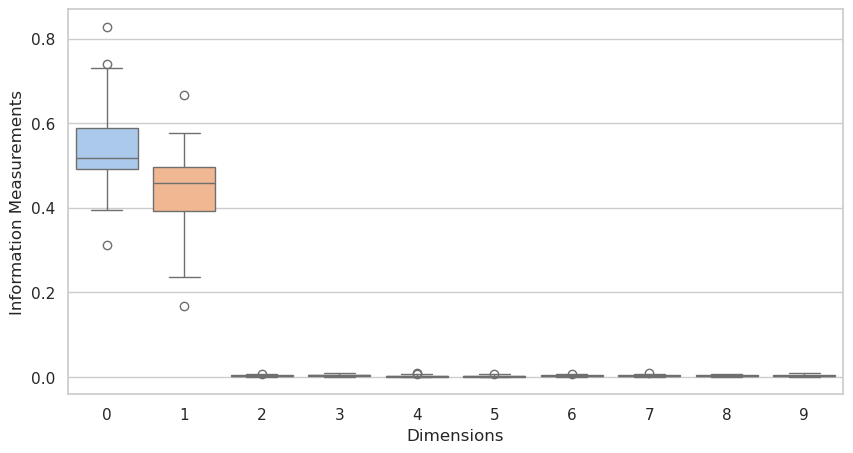

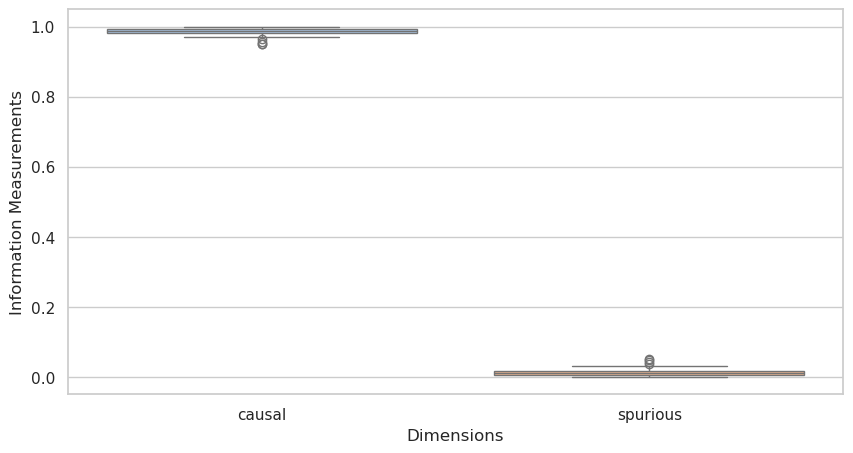

(            0         1         2         3         4         5         6  \
 A1   0.524907  0.451544  0.002385  0.004177  0.002489  0.001596  0.004022   
 A2   0.597220  0.364063  0.005251  0.006858  0.002189  0.002709  0.005120   
 A3   0.457608  0.516787  0.002057  0.003200  0.001806  0.002857  0.002893   
 A4   0.509703  0.461390  0.003265  0.004623  0.002165  0.002186  0.004340   
 A5   0.598944  0.381025  0.003355  0.003202  0.001371  0.002343  0.001705   
 A6   0.739513  0.251651  0.001365  0.002118  0.000341  0.000453  0.000590   
 A7   0.598032  0.388858  0.003271  0.002092  0.000582  0.000569  0.000979   
 A8   0.394622  0.575781  0.002056  0.003695  0.003354  0.003242  0.003407   
 A9   0.616491  0.380930  0.000464  0.000402  0.000180  0.000092  0.000291   
 A10  0.674995  0.297843  0.003504  0.006259  0.001081  0.000890  0.001446   
 A11  0.662705  0.327885  0.002326  0.002798  0.000401  0.000703  0.000456   
 A12  0.479497  0.513900  0.000812  0.001296  0.000524  0.000338

In [65]:
model_1L.compute_information_flow(plot_info_flow=True, save_fig=True, save_dir=output_dir)

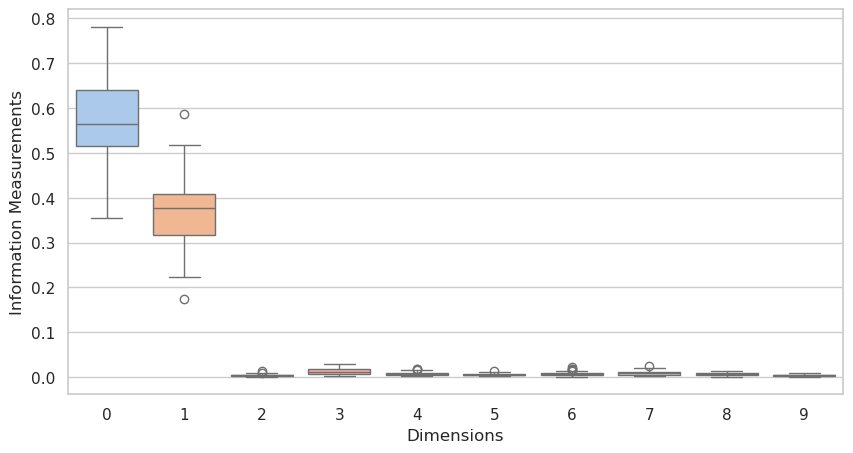

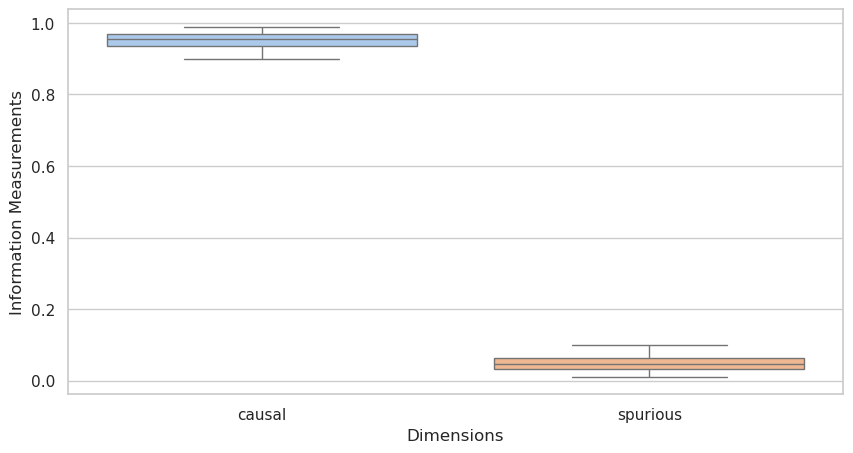

(            0         1         2         3         4         5         6  \
 A1   0.630852  0.318585  0.003944  0.010081  0.008394  0.004038  0.005039   
 A2   0.764985  0.223592  0.000991  0.002227  0.001554  0.001667  0.001201   
 A3   0.724908  0.224540  0.003001  0.011070  0.007717  0.004274  0.007849   
 A4   0.531217  0.370330  0.006179  0.016631  0.018012  0.011826  0.013029   
 A5   0.584612  0.396728  0.001299  0.004230  0.002651  0.001875  0.002716   
 A6   0.522168  0.390127  0.005233  0.017971  0.012055  0.006570  0.014431   
 A7   0.483343  0.448730  0.005821  0.016985  0.010296  0.008155  0.004118   
 A8   0.562059  0.381275  0.006224  0.014725  0.005924  0.007489  0.005646   
 A9   0.579477  0.368723  0.006213  0.008844  0.007335  0.005332  0.003678   
 A10  0.520144  0.390575  0.006226  0.023117  0.007767  0.011165  0.011706   
 A11  0.661750  0.298141  0.003913  0.004610  0.006608  0.003019  0.004876   
 A12  0.673785  0.283051  0.002476  0.010025  0.007173  0.003379

In [66]:
model_2L.compute_information_flow(plot_info_flow=True, save_fig=True, save_dir=output_dir)

In [72]:
# adata_protein = sc.AnnData(X=np.concatenate([microb.T, prot.T], axis=1))
adata_protein = sc.AnnData(X=microb.T)
adata_protein.var_names = microb_df.index
adata_protein.obs['labels_ori'] = labels.values
adata_protein.obs['labels'] = labels.apply(lambda tg: 1 if tg == labels[0] else 0)
adata_protein.obsm['X_ct_1'] = model_1L.get_model_output()['latent'][:,:2]
adata_protein.obsm['X_ct_2'] = model_2L.get_model_output()['latent'][:,:2]


In [73]:
sc.pp.neighbors(adata_protein)

         Falling back to preprocessing with `sc.pp.pca` and default params.


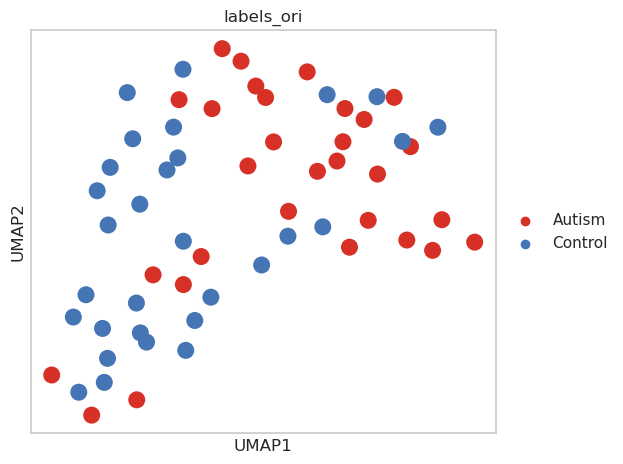

In [81]:
sc.tl.umap(adata_protein)
sc.pl.umap(adata_protein, color='labels_ori', palette={"Autism": "#D73027", "Control": "#4575B4"}, show=False, size=600)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'umap.pdf'))

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(adata_layer2.X)


loadings = pca.components_.T

df = pd.DataFrame(loadings[:, :2], columns=['PC1', 'PC2'], index=adata_layer2.var_names)

df['PC1_abs'] = np.abs(df['PC1'])
df['PC2_abs'] = np.abs(df['PC2'])

In [46]:
adata_layer2pca = pca.transform(adata_layer2.X)

In [51]:
adata_layer2.obs['labels_ori'].values

['Autism', 'Autism', 'Autism', 'Autism', 'Autism', ..., 'Control', 'Control', 'Control', 'Control', 'Control']
Length: 60
Categories (2, object): ['Autism', 'Control']

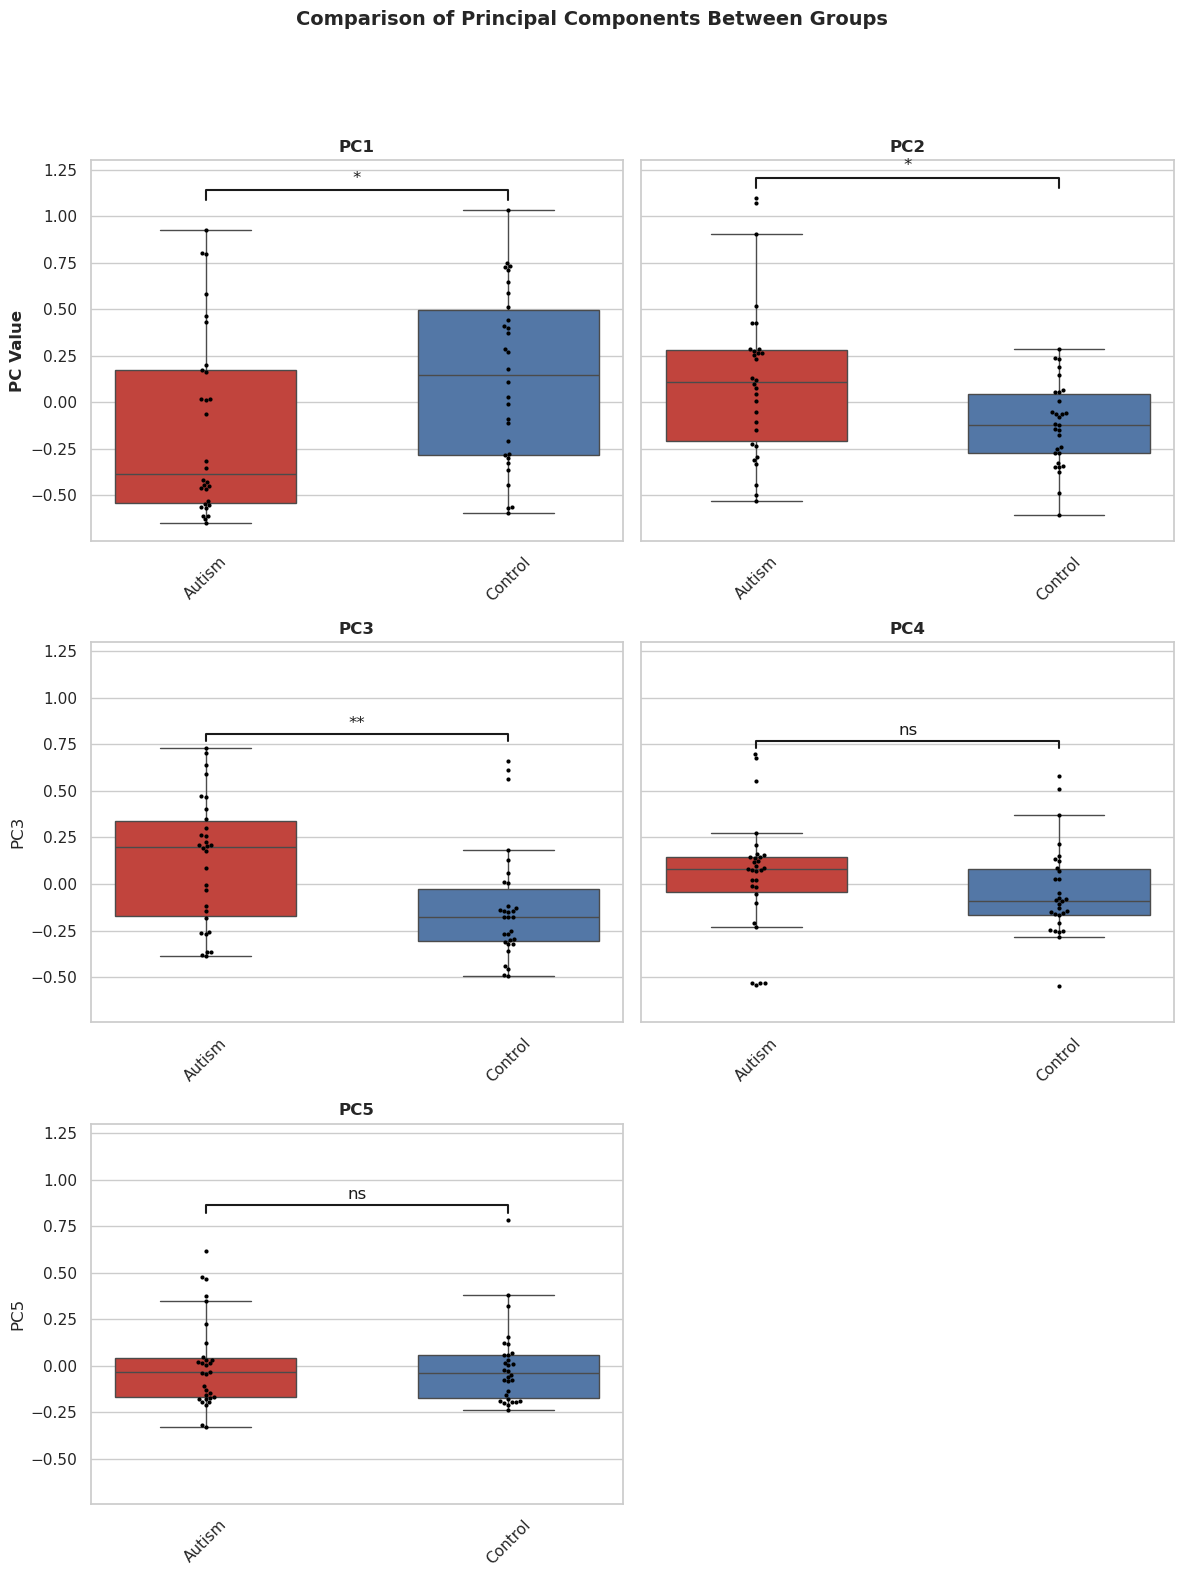

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

sns.set(style="whitegrid", palette="pastel")

k = 5
df = pd.DataFrame(adata_layer2pca[:, :k], columns=[f'PC{i+1}' for i in range(k)])
df['Group'] = adata_layer2.obs['labels_ori'].values

n_cols = 2
n_rows = int(np.ceil(k / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
axes = axes.flatten()

palette = {"Autism": "#D73027", "Control": "#4575B4"}

for i, ax in enumerate(axes):
    if i >= k:
        ax.axis('off')
        continue
    
    pc_name = f'PC{i+1}'

    sns.boxplot(
        x='Group', 
        y=pc_name, 
        data=df, 
        ax=ax,
        palette=palette,
        width=0.6,
        showfliers=False
    )
    
    sns.swarmplot(
        x='Group',
        y=pc_name,
        data=df,
        ax=ax,
        color='black',
        alpha=1,
        size=3
    )
    
    group1 = df[df['Group'] == df['Group'].unique()[0]][pc_name]
    group2 = df[df['Group'] == df['Group'].unique()[1]][pc_name]
    _, p_value = mannwhitneyu(group1, group2)
    
    y_max = df[pc_name].max()
    h = y_max * 0.05
    ax.plot([0, 0, 1, 1], [y_max+h, y_max+2*h, y_max+2*h, y_max+h], lw=1.5, c='k')
    
    if p_value < 0.001:
        symbol = '***'
    elif p_value < 0.01:
        symbol = '**'
    elif p_value < 0.05:
        symbol = '*'
    else:
        symbol = 'ns'
    
    ax.text(0.5, y_max+2.5*h, symbol, ha='center', va='bottom', color='k')
    
    ax.set_title(pc_name, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('PC Value', fontweight='bold')

plt.suptitle('Comparison of Principal Components Between Groups', y=1.05, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir+'compare_PC1-5.pdf')
plt.show()

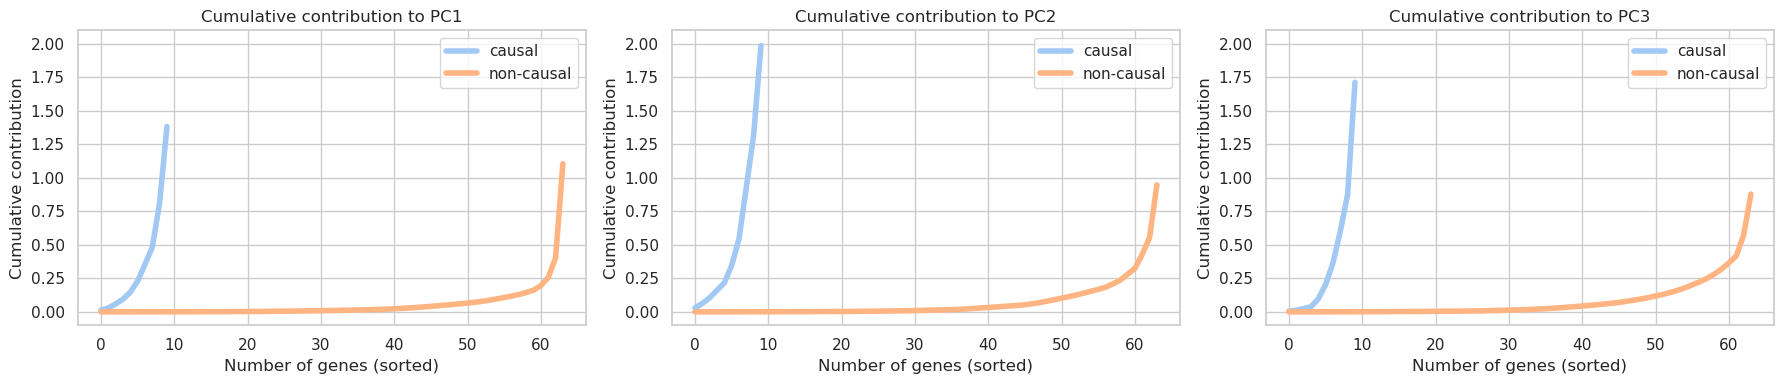

In [64]:
def plot_cumulative_contributions(pca, k=2, figsize=(6, 4)):

    loading_dict = {
        f'PC{i+1}_loading': np.abs(pca.components_[i])
        for i in range(k)
    }
    df = pd.DataFrame({
        'gene': adata_layer2.var_names,
        'group': ['causal' if g in df_layer2.head(10).index else 'non-causal' for g in adata_layer2.var_names],
        **loading_dict
    })

    fig, axes = plt.subplots(1, k, figsize=(figsize[0]*k, figsize[1]))

    if k == 1:
        axes = [axes]

    for i in range(k):
        pc_col = f'PC{i+1}_loading'
        curves = {}

        for group in df['group'].unique():
            subset = df[df['group'] == group].copy()
            sorted_vals = np.sort(subset[pc_col].values)
            cum = np.cumsum(sorted_vals)
            curves[group] = cum

        ax = axes[i]
        for group, cum in curves.items():
            x = np.arange(len(cum))
            ax.plot(x, cum, label=group, linewidth=4)

        ax.set_title(f"Cumulative contribution to PC{i+1}")
        ax.set_xlabel("Number of genes (sorted)")
        ax.set_ylabel("Cumulative contribution")
        ax.set_ylim(-0.1, 2.1)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(output_dir + 'cum_PC.pdf')
    plt.show()

plot_cumulative_contributions(pca, k=3)

In [218]:
df = microb.T
df = pd.DataFrame(df, columns=microb_df.index, index=microb_df.columns)
df = df.astype(float)

In [219]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

pvals = []
log2fcs = []

for col in df.columns:
    a = df[df_index_groups == 'Autism'][col]
    c = df[df_index_groups == 'Control'][col]

    stat, p = mannwhitneyu(a, c, alternative='two-sided')
    pvals.append(p)

    mean_a = np.mean(a)
    mean_c = np.mean(c)
    log2fc = np.log2((mean_a + 1e-8) / (mean_c + 1e-8))
    log2fcs.append(log2fc)

adj_pvals = multipletests(pvals, method='fdr_bh')[1]

deg = pd.DataFrame({
    'feature': df.columns,
    'log2FC': log2fcs,
    'pval': pvals,
    'adj_pval': adj_pvals
})
deg['is_trigger'] = [1 if i in df_layer2.head(10).index else 0 for i in deg.feature]

In [220]:
pval_thresh = 0.05
log2fc_thresh = 1

deg['significance'] = 'Not Significant'
deg.loc[(deg['adj_pval'] < pval_thresh) & (deg['log2FC'] > log2fc_thresh), 'significance'] = 'Autism Up'
deg.loc[(deg['adj_pval'] < pval_thresh) & (deg['log2FC'] < -log2fc_thresh), 'significance'] = 'Autism Down'

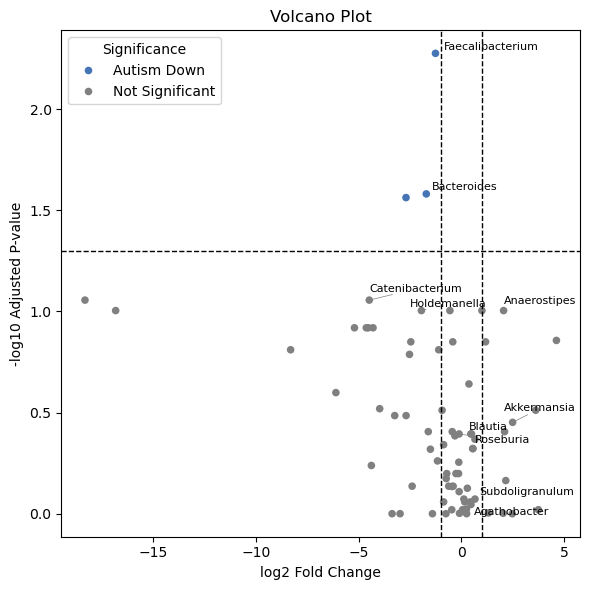

In [19]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=deg,
    x='log2FC',
    y=-np.log10(deg['adj_pval']),
    hue='significance',
    palette={'Autism Up': '#d73027', 'Autism Down': '#4575b4', 'Not Significant': 'gray'},
    s=30,
    edgecolor='none'
)

from adjustText import adjust_text

top_genes = deg.loc[deg.is_trigger == 1,:]
texts = []
for i, row in top_genes.iterrows():
    texts.append(
        plt.text(row['log2FC'], -np.log10(row['adj_pval']), row['feature'], fontsize=8)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
plt.axvline(log2fc_thresh, color='black', linestyle='--', linewidth=1)
plt.axvline(-log2fc_thresh, color='black', linestyle='--', linewidth=1)

plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted P-value')
plt.title('Volcano Plot')
plt.legend(title='Significance', loc='best')
plt.tight_layout()

plt.savefig(os.path.join(output_dir, "volcano_plot.pdf"))
plt.show()

In [223]:
deg.loc[deg.significance == 'Autism Down', :]

,feature,log2FC,pval,adj_pval,is_trigger,significance
0,Bacteroides,-1.705165,0.000709,0.026230,1,Autism Down
13,Escherichia,-2.692314,0.001109,0.027357,0,Autism Down
59,Faecalibacterium,-1.257797,0.000072,0.005295,1,Autism Down


In [71]:
adata_TF = adata_layer2.copy()
adata_down = X_down.copy()
adata_down.obsm['X_umap'] = adata_protein.obsm['X_umap']

In [220]:
def plot_vector_field(adata,pert_Gene=None,pert_celltype=None,state_obs=None,embedding_name=None,
                      sampled_fraction=1, min_mass=0.008,scale=0.1, save_dir=None,smooth=0.8,n_grid=40,
                     n_suggestion=12,show=True,dot_size=None,run_suggest_mass_thresholds=False,direction=None,n_neighbors=None,):
    from scipy import sparse
    from sklearn.neighbors import NearestNeighbors
    from velocyto.estimation import colDeltaCorpartial
    from scipy.stats import norm as normal
    import math

    def estimate_transition_prob(adata, embedding_name,sampled_fraction, n_neighbors=None, sigma_corr=0.005):
        sampling_probs = (0.5, 0.1)
        X = adata.layers["imputed_count"].transpose().copy()
        delta_X = adata.layers["delta_X"].transpose().copy()
        embedding = adata.obsm[embedding_name].copy()
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=4)
        nn.fit(embedding)
        embedding_knn = nn.kneighbors_graph(mode="connectivity")
        neigh_ixs = embedding_knn.indices.reshape((-1, n_neighbors + 1))
        p = np.linspace(sampling_probs[0], sampling_probs[1], neigh_ixs.shape[1])
        p = p / p.sum()
        sampling_ixs = np.stack([np.random.choice(neigh_ixs.shape[1],
                                                  size=(int(sampled_fraction * (n_neighbors + 1)),),
                                                  replace=False,
                                                  p=p) for i in range(neigh_ixs.shape[0])], 0)
        neigh_ixs = neigh_ixs[np.arange(neigh_ixs.shape[0])[:, None], sampling_ixs]
        nonzero = neigh_ixs.shape[0] * neigh_ixs.shape[1]
        embedding_knn = sparse.csr_matrix((np.ones(nonzero),
                                           neigh_ixs.ravel(),
                                           np.arange(0, nonzero + 1, neigh_ixs.shape[1])),
                                          shape=(neigh_ixs.shape[0],
                                                 neigh_ixs.shape[0]))
        adata.uns['neigh_ixs'] = neigh_ixs.copy()
        corrcoef = colDeltaCorpartial(X, delta_X, neigh_ixs)
        if np.any(np.isnan(corrcoef)):
            corrcoef[np.isnan(corrcoef)] = 1
        transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A
        transition_prob /= transition_prob.sum(1)[:, None]
        adata.obsm['embedding_knn'] = embedding_knn.copy()
        adata.obsp['transition_prob'] = transition_prob.copy()

    def calculate_embedding_shift(adata, embedding_name):
        transition_prob = adata.obsp['transition_prob'].copy()
        embedding = adata.obsm[embedding_name].copy()
        embedding_knn = adata.obsm['embedding_knn'].copy()
        unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
        with np.errstate(divide='ignore', invalid='ignore'):
            unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
            np.fill_diagonal(unitary_vectors[0, ...], 0)
            np.fill_diagonal(unitary_vectors[1, ...], 0)
        delta_embedding = (transition_prob * unitary_vectors).sum(2)
        delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
        delta_embedding = delta_embedding.T
        adata.obsm['delta_embedding'] = delta_embedding.copy()

    def calculate_p_mass(adata,state_obs,pert_celltype, embedding_name, smooth, n_grid, n_neighbors=None):
        steps = (n_grid, n_grid)
        embedding = adata.obsm[embedding_name].copy()
        adata_tmp = adata.copy()
        adata_tmp.obsm['delta_embedding'][~adata_tmp.obs[state_obs].isin(pert_celltype)] = 0
        delta_embedding = adata_tmp.obsm['delta_embedding'].copy()
        grs = []
        for dim_i in range(embedding.shape[1]):
            m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])
            m = m - 0.025 * np.abs(M - m)
            M = M + 0.025 * np.abs(M - m)
            gr = np.linspace(m, M, steps[dim_i])
            grs.append(gr)
        meshes_tuple = np.meshgrid(*grs)
        gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(embedding)
        dists, neighs = nn.kneighbors(gridpoints_coordinates)
        std = np.mean([(g[1] - g[0]) for g in grs])
        gaussian_w = normal.pdf(loc=0, scale=smooth * std, x=dists)
        total_p_mass = gaussian_w.sum(1)
        UZ = (delta_embedding[neighs] * gaussian_w[:, :, None]).sum(1) / np.maximum(1, total_p_mass)[:,None]
        magnitude = np.linalg.norm(UZ, axis=1)
        flow_embedding = embedding
        flow_grid = gridpoints_coordinates
        flow = UZ
        flow_norm = UZ / np.percentile(magnitude, 99.5)
        flow_norm_magnitude = np.linalg.norm(flow_norm, axis=1)
        adata.uns['total_p_mass'] = total_p_mass.copy()
        adata.uns['flow_grid'] = flow_grid.copy()
        adata.uns['flow'] = flow.copy()

    def suggest_mass_thresholds(adata, embedding_name, n_suggestion,save_dir, s=1, n_col=4):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        min_ = total_p_mass.min()
        max_ = total_p_mass.max()
        suggestions = np.linspace(min_, max_ / 2, n_suggestion)
        n_rows = math.ceil(n_suggestion / n_col)
        fig, ax = plt.subplots(n_rows, n_col, figsize=[5 * n_col, 5 * n_rows])
        if n_rows == 1:
            ax = ax.reshape(1, -1)
        row = 0
        col = 0
        for i in range(n_suggestion):
            ax_ = ax[row, col]
            col += 1
            if col == n_col:
                col = 0
                row += 1
            idx = total_p_mass > suggestions[i]
            ax_.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=s)
            ax_.scatter(flow_grid[idx, 0],
                        flow_grid[idx, 1],
                        c="black", s=s)
            ax_.set_title(f"min_mass: {suggestions[i]: .2g}")
            ax_.axis("off")
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/suggest_mass_thresholds.png", bbox_inches='tight')
        plt.show()

    def calculate_mass_filter(adata, embedding_name, min_mass, plot=False):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        mass_filter = (total_p_mass < min_mass)
        adata.uns['mass_filter'] = mass_filter.copy()
        if plot:
            fig, ax = plt.subplots(figsize=[5, 5])
            ax.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=10)
            ax.scatter(flow_grid[~mass_filter, 0],
                       flow_grid[~mass_filter, 1],
                       c="black", s=0.5)
            ax.set_title("Grid points selected")
            ax.axis("off")
            plt.show()

    def plot_flow(adata, state_obs, embedding_name, dot_size, scale, pert_Gene, save_dir, show,direction):
        fig, ax = plt.subplots()
        sc.pl.embedding(adata, basis=embedding_name, color=state_obs, ax=ax, show=False,size=dot_size)
        ax.set_title("")
        if ax.get_legend() is not None:
            ax.get_legend().set_visible(False)
        mass_filter = adata.uns['mass_filter'].copy()
        gridpoints_coordinates = adata.uns['flow_grid'].copy()
        flow = adata.uns['flow'].copy()
        ax.quiver(gridpoints_coordinates[~mass_filter, 0],
                           gridpoints_coordinates[~mass_filter, 1],
                           flow[~mass_filter, 0],
                           flow[~mass_filter, 1],
                           scale=scale)
        ax.axis("off")
        if direction == 'Activation':
            ax.set_title(f"{' and '.join(pert_Gene)} {direction}")
        elif direction =='both':
            ax.set_title(f"{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out")
        else:
            ax.set_title(f"{' and '.join(pert_Gene)} Knock Out")
        plt.tight_layout()
        if save_dir:
            if direction == 'Activation':
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.pdf", bbox_inches='tight', backend='Cairo')
            elif direction =='both':
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
            else:
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
        if show:
            plt.show()

    estimate_transition_prob(adata,embedding_name=embedding_name, n_neighbors=n_neighbors, sampled_fraction=sampled_fraction)
    calculate_embedding_shift(adata,embedding_name=embedding_name)
    calculate_p_mass(adata,embedding_name=embedding_name,n_neighbors=n_neighbors,pert_celltype=pert_celltype, smooth=smooth, n_grid=n_grid, state_obs=state_obs)
    if run_suggest_mass_thresholds:
        suggest_mass_thresholds(adata, embedding_name=embedding_name,n_suggestion=n_suggestion,save_dir=save_dir)
        return adata
    calculate_mass_filter(adata,embedding_name=embedding_name, min_mass=min_mass, plot=False)
    plot_flow(adata,state_obs=state_obs, embedding_name=embedding_name,dot_size=dot_size, scale=scale,show=show,direction=direction,pert_Gene=pert_Gene, save_dir=save_dir)
    return adata


def pert_plot_vector_field(adata_TF, adata_down, model, pert_Gene,pert_celltype, run_suggest_mass_thresholds,fold,state_obs,dot_size=None, scale=0.1, min_mass=0.008,save_dir=None,embedding_name='X_tsne',n_neighbors=None,n_grid=40):
    model.eval()
    with torch.no_grad():
        model_output = model.get_model_output(adata_TF)
    adata_pert = adata_TF.copy()
    pert_cell_idx = np.where(adata_TF.obs[state_obs].isin(pert_celltype))[0]
    for ind, gene in enumerate(pert_Gene):
        adata_pert.X[:, adata_pert.var_names.get_loc(gene)] = adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)].max() * fold[ind]
    model.eval()
    with torch.no_grad():
        model_output_pert = model.get_model_output(adata_pert)

    adata_down.layers["imputed_count"] = np.float64(np.exp(model_output['x_down_rec_alpha']))
    # adata_down.layers["imputed_count"] = np.float64(np.exp(adata_down.X.copy()))

    adata_down.layers["simulated_count"] = np.float64(np.exp(model_output_pert['x_down_rec_alpha']))
    adata_down.layers["delta_X"] = adata_down.layers["simulated_count"].copy() - adata_down.layers["imputed_count"].copy()
    ax = plot_vector_field(adata_down, embedding_name=embedding_name,direction='Activation', state_obs=state_obs,
                                   pert_Gene=pert_Gene, pert_celltype=pert_celltype, scale=scale,min_mass=min_mass, save_dir=save_dir,dot_size=dot_size,run_suggest_mass_thresholds=run_suggest_mass_thresholds,n_neighbors=n_neighbors,n_grid=n_grid)

In [85]:
def plot_stream(adata,pert_Gene=None,pert_celltype=None,state_obs=None,embedding_name=None,
                      sampled_fraction=1, min_mass=0.008,scale=0.1, save_dir=None,smooth=0.8,n_grid=40,
                     n_suggestion=12,show=True,dot_size=None,run_suggest_mass_thresholds=False,direction=None,n_neighbors=None,palette=None):
    from scipy import sparse
    from sklearn.neighbors import NearestNeighbors
    from velocyto.estimation import colDeltaCorpartial
    from scipy.stats import norm as normal
    import math

    def estimate_transition_prob(adata, embedding_name,sampled_fraction, n_neighbors=None, sigma_corr=0.005):
        sampling_probs = (0.5, 0.1)
        X = adata.layers["imputed_count"].transpose().copy()
        delta_X = adata.layers["delta_X"].transpose().copy()
        embedding = adata.obsm[embedding_name].copy()
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=4)
        nn.fit(embedding)
        embedding_knn = nn.kneighbors_graph(mode="connectivity")
        neigh_ixs = embedding_knn.indices.reshape((-1, n_neighbors + 1))
        p = np.linspace(sampling_probs[0], sampling_probs[1], neigh_ixs.shape[1])
        p = p / p.sum()
        sampling_ixs = np.stack([np.random.choice(neigh_ixs.shape[1],
                                                  size=(int(sampled_fraction * (n_neighbors + 1)),),
                                                  replace=False,
                                                  p=p) for i in range(neigh_ixs.shape[0])], 0)
        neigh_ixs = neigh_ixs[np.arange(neigh_ixs.shape[0])[:, None], sampling_ixs]
        nonzero = neigh_ixs.shape[0] * neigh_ixs.shape[1]
        embedding_knn = sparse.csr_matrix((np.ones(nonzero),
                                           neigh_ixs.ravel(),
                                           np.arange(0, nonzero + 1, neigh_ixs.shape[1])),
                                          shape=(neigh_ixs.shape[0],
                                                 neigh_ixs.shape[0]))
        adata.uns['neigh_ixs'] = neigh_ixs.copy()
        corrcoef = colDeltaCorpartial(X, delta_X, neigh_ixs)
        if np.any(np.isnan(corrcoef)):
            corrcoef[np.isnan(corrcoef)] = 1
        transition_prob = np.exp(corrcoef / sigma_corr) * embedding_knn.A
        transition_prob /= transition_prob.sum(1)[:, None]
        adata.obsm['embedding_knn'] = embedding_knn.copy()
        adata.obsp['transition_prob'] = transition_prob.copy()

    def calculate_embedding_shift(adata, embedding_name):
        transition_prob = adata.obsp['transition_prob'].copy()
        embedding = adata.obsm[embedding_name].copy()
        embedding_knn = adata.obsm['embedding_knn'].copy()
        unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
        with np.errstate(divide='ignore', invalid='ignore'):
            unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
            np.fill_diagonal(unitary_vectors[0, ...], 0)
            np.fill_diagonal(unitary_vectors[1, ...], 0)
        delta_embedding = (transition_prob * unitary_vectors).sum(2)
        delta_embedding -= (embedding_knn.A * unitary_vectors).sum(2) / embedding_knn.sum(1).A.T
        delta_embedding = delta_embedding.T
        adata.obsm['delta_embedding'] = delta_embedding.copy()

    def calculate_p_mass(adata,state_obs,pert_celltype, embedding_name, smooth, n_grid, n_neighbors=None):
        steps = (n_grid, n_grid)
        embedding = adata.obsm[embedding_name].copy()
        adata_tmp = adata.copy()
        adata_tmp.obsm['delta_embedding'][~adata_tmp.obs[state_obs].isin(pert_celltype)] = 0
        delta_embedding = adata_tmp.obsm['delta_embedding'].copy()
        grs = []
        for dim_i in range(embedding.shape[1]):
            m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])
            m = m - 0.025 * np.abs(M - m)
            M = M + 0.025 * np.abs(M - m)
            gr = np.linspace(m, M, steps[dim_i])
            grs.append(gr)
        meshes_tuple = np.meshgrid(*grs)
        gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
        if n_neighbors is None:
            n_neighbors = int(adata.shape[0] / 5)
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(embedding)
        dists, neighs = nn.kneighbors(gridpoints_coordinates)
        std = np.mean([(g[1] - g[0]) for g in grs])
        gaussian_w = normal.pdf(loc=0, scale=smooth * std, x=dists)
        total_p_mass = gaussian_w.sum(1)
        UZ = (delta_embedding[neighs] * gaussian_w[:, :, None]).sum(1) / np.maximum(1, total_p_mass)[:,None]
        magnitude = np.linalg.norm(UZ, axis=1)
        flow_embedding = embedding
        flow_grid = gridpoints_coordinates
        flow = UZ
        flow_norm = UZ / np.percentile(magnitude, 99.5)
        flow_norm_magnitude = np.linalg.norm(flow_norm, axis=1)
        adata.uns['total_p_mass'] = total_p_mass.copy()
        adata.uns['flow_grid'] = flow_grid.copy()
        adata.uns['flow'] = flow.copy()

    def suggest_mass_thresholds(adata, embedding_name, n_suggestion,save_dir, s=1, n_col=4):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        min_ = total_p_mass.min()
        max_ = total_p_mass.max()
        suggestions = np.linspace(min_, max_ / 2, n_suggestion)
        n_rows = math.ceil(n_suggestion / n_col)
        fig, ax = plt.subplots(n_rows, n_col, figsize=[5 * n_col, 5 * n_rows])
        if n_rows == 1:
            ax = ax.reshape(1, -1)
        row = 0
        col = 0
        for i in range(n_suggestion):
            ax_ = ax[row, col]
            col += 1
            if col == n_col:
                col = 0
                row += 1
            idx = total_p_mass > suggestions[i]
            ax_.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=s)
            ax_.scatter(flow_grid[idx, 0],
                        flow_grid[idx, 1],
                        c="black", s=s)
            ax_.set_title(f"min_mass: {suggestions[i]: .2g}")
            ax_.axis("off")
        plt.tight_layout()
        if save_dir:
            plt.savefig(f"{save_dir}/suggest_mass_thresholds.png", bbox_inches='tight')
        plt.show()

    def calculate_mass_filter(adata, embedding_name, min_mass, plot=False):
        embedding = adata.obsm[embedding_name].copy()
        total_p_mass = adata.uns['total_p_mass'].copy()
        flow_grid = adata.uns['flow_grid'].copy()
        mass_filter = (total_p_mass < min_mass)
        adata.uns['mass_filter'] = mass_filter.copy()
        if plot:
            fig, ax = plt.subplots(figsize=[5, 5])
            ax.scatter(embedding[:, 0], embedding[:, 1], c="lightgray", s=10)
            ax.scatter(flow_grid[~mass_filter, 0],
                       flow_grid[~mass_filter, 1],
                       c="black", s=0.5)
            ax.set_title("Grid points selected")
            ax.axis("off")
            plt.show()

    def plot_flow(adata, state_obs, embedding_name, dot_size, scale, pert_Gene, save_dir, show,direction,palette=None):
        fig, ax = plt.subplots()
        sc.pl.embedding(adata, basis=embedding_name, color=state_obs, ax=ax, show=False,size=dot_size, palette=palette)
        ax.set_title("")
        if ax.get_legend() is not None:
            ax.get_legend().set_visible(False)
        mass_filter = adata.uns['mass_filter'].copy()
        gridpoints_coordinates = adata.uns['flow_grid'].copy()
        flow = adata.uns['flow'].copy()


        from scipy.interpolate import griddata
        
        # 原始稀疏坐标与流场
        xy = adata.uns['flow_grid'][~mass_filter]        # shape: [N, 2]
        uv = adata.uns['flow'][~mass_filter]             # shape: [N, 2]
        
        # 生成规则网格坐标
        x_lin = np.linspace(xy[:, 0].min(), xy[:, 0].max(), 40)
        y_lin = np.linspace(xy[:, 1].min(), xy[:, 1].max(), 40)
        X, Y = np.meshgrid(x_lin, y_lin)
        
        # 插值 U 和 V 分量
        U = griddata(xy, uv[:, 0], (X, Y), method='linear', fill_value=0)
        V = griddata(xy, uv[:, 1], (X, Y), method='linear', fill_value=0)
        
        # 可视化
        ax.streamplot(x_lin, y_lin, U, V,
                      color='black',
                      density=1.2,
                      linewidth=1,
                      arrowsize=1.5,
                      integration_direction='both')

        
        ax.axis("off")
        if direction == 'Activation':
            ax.set_title(f"{' and '.join(pert_Gene)} {direction}")
        elif direction =='both':
            ax.set_title(f"{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out")
        else:
            ax.set_title(f"{' and '.join(pert_Gene)} Knock Out")
        plt.tight_layout()
        if save_dir:
            if direction == 'Activation':
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} {direction}.pdf", bbox_inches='tight', backend='Cairo')
            elif direction =='both':
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{pert_Gene[0]} Activation and {pert_Gene[1]} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
            else:
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.png", bbox_inches='tight')
                plt.savefig(f"{save_dir}/{' and '.join(pert_Gene)} Knock Out.pdf", bbox_inches='tight', backend='Cairo')
        if show:
            plt.show()

    estimate_transition_prob(adata,embedding_name=embedding_name, n_neighbors=n_neighbors, sampled_fraction=sampled_fraction)
    calculate_embedding_shift(adata,embedding_name=embedding_name)
    calculate_p_mass(adata,embedding_name=embedding_name,n_neighbors=n_neighbors,pert_celltype=pert_celltype, smooth=smooth, n_grid=n_grid, state_obs=state_obs)
    if run_suggest_mass_thresholds:
        suggest_mass_thresholds(adata, embedding_name=embedding_name,n_suggestion=n_suggestion,save_dir=save_dir)
        return adata
    calculate_mass_filter(adata,embedding_name=embedding_name, min_mass=min_mass, plot=False)
    plot_flow(adata,state_obs=state_obs, embedding_name=embedding_name,dot_size=dot_size, scale=scale,show=show,direction=direction,pert_Gene=pert_Gene, save_dir=save_dir,palette=palette)
    return adata


def pert_plot_stream(adata_TF, adata_down, model, pert_Gene,pert_celltype, run_suggest_mass_thresholds,fold,state_obs,dot_size=None, scale=0.1, min_mass=0.008,save_dir=None,embedding_name='X_tsne',n_neighbors=None,n_grid=40,palette=None):
    model.eval()
    with torch.no_grad():
        model_output = model.get_model_output(adata_TF)
    adata_pert = adata_TF.copy()
    pert_cell_idx = np.where(adata_TF.obs[state_obs].isin(pert_celltype))[0]
    for ind, gene in enumerate(pert_Gene):
        adata_pert.X[:, adata_pert.var_names.get_loc(gene)] = adata_pert.X[pert_cell_idx, adata_pert.var_names.get_loc(gene)].max() * fold[ind]
    model.eval()
    with torch.no_grad():
        model_output_pert = model.get_model_output(adata_pert)

    adata_down.layers["imputed_count"] = np.float64(np.exp(model_output['x_down_rec_alpha']))
    # adata_down.layers["imputed_count"] = np.float64(np.exp(adata_down.X.copy()))

    adata_down.layers["simulated_count"] = np.float64(np.exp(model_output_pert['x_down_rec_alpha']))
    adata_down.layers["delta_X"] = adata_down.layers["simulated_count"].copy() - adata_down.layers["imputed_count"].copy()
    ax = plot_stream(adata_down, embedding_name=embedding_name,direction='Activation', state_obs=state_obs,
                                   pert_Gene=pert_Gene, pert_celltype=pert_celltype, scale=scale,min_mass=min_mass, 
                            save_dir=save_dir,dot_size=dot_size,run_suggest_mass_thresholds=run_suggest_mass_thresholds,n_neighbors=n_neighbors,n_grid=n_grid,
                           palette=palette)
    return model_output_pert

In [410]:
dot_size = 800
pert_Gene = ['Faecalibacterium']
fold = [2]

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


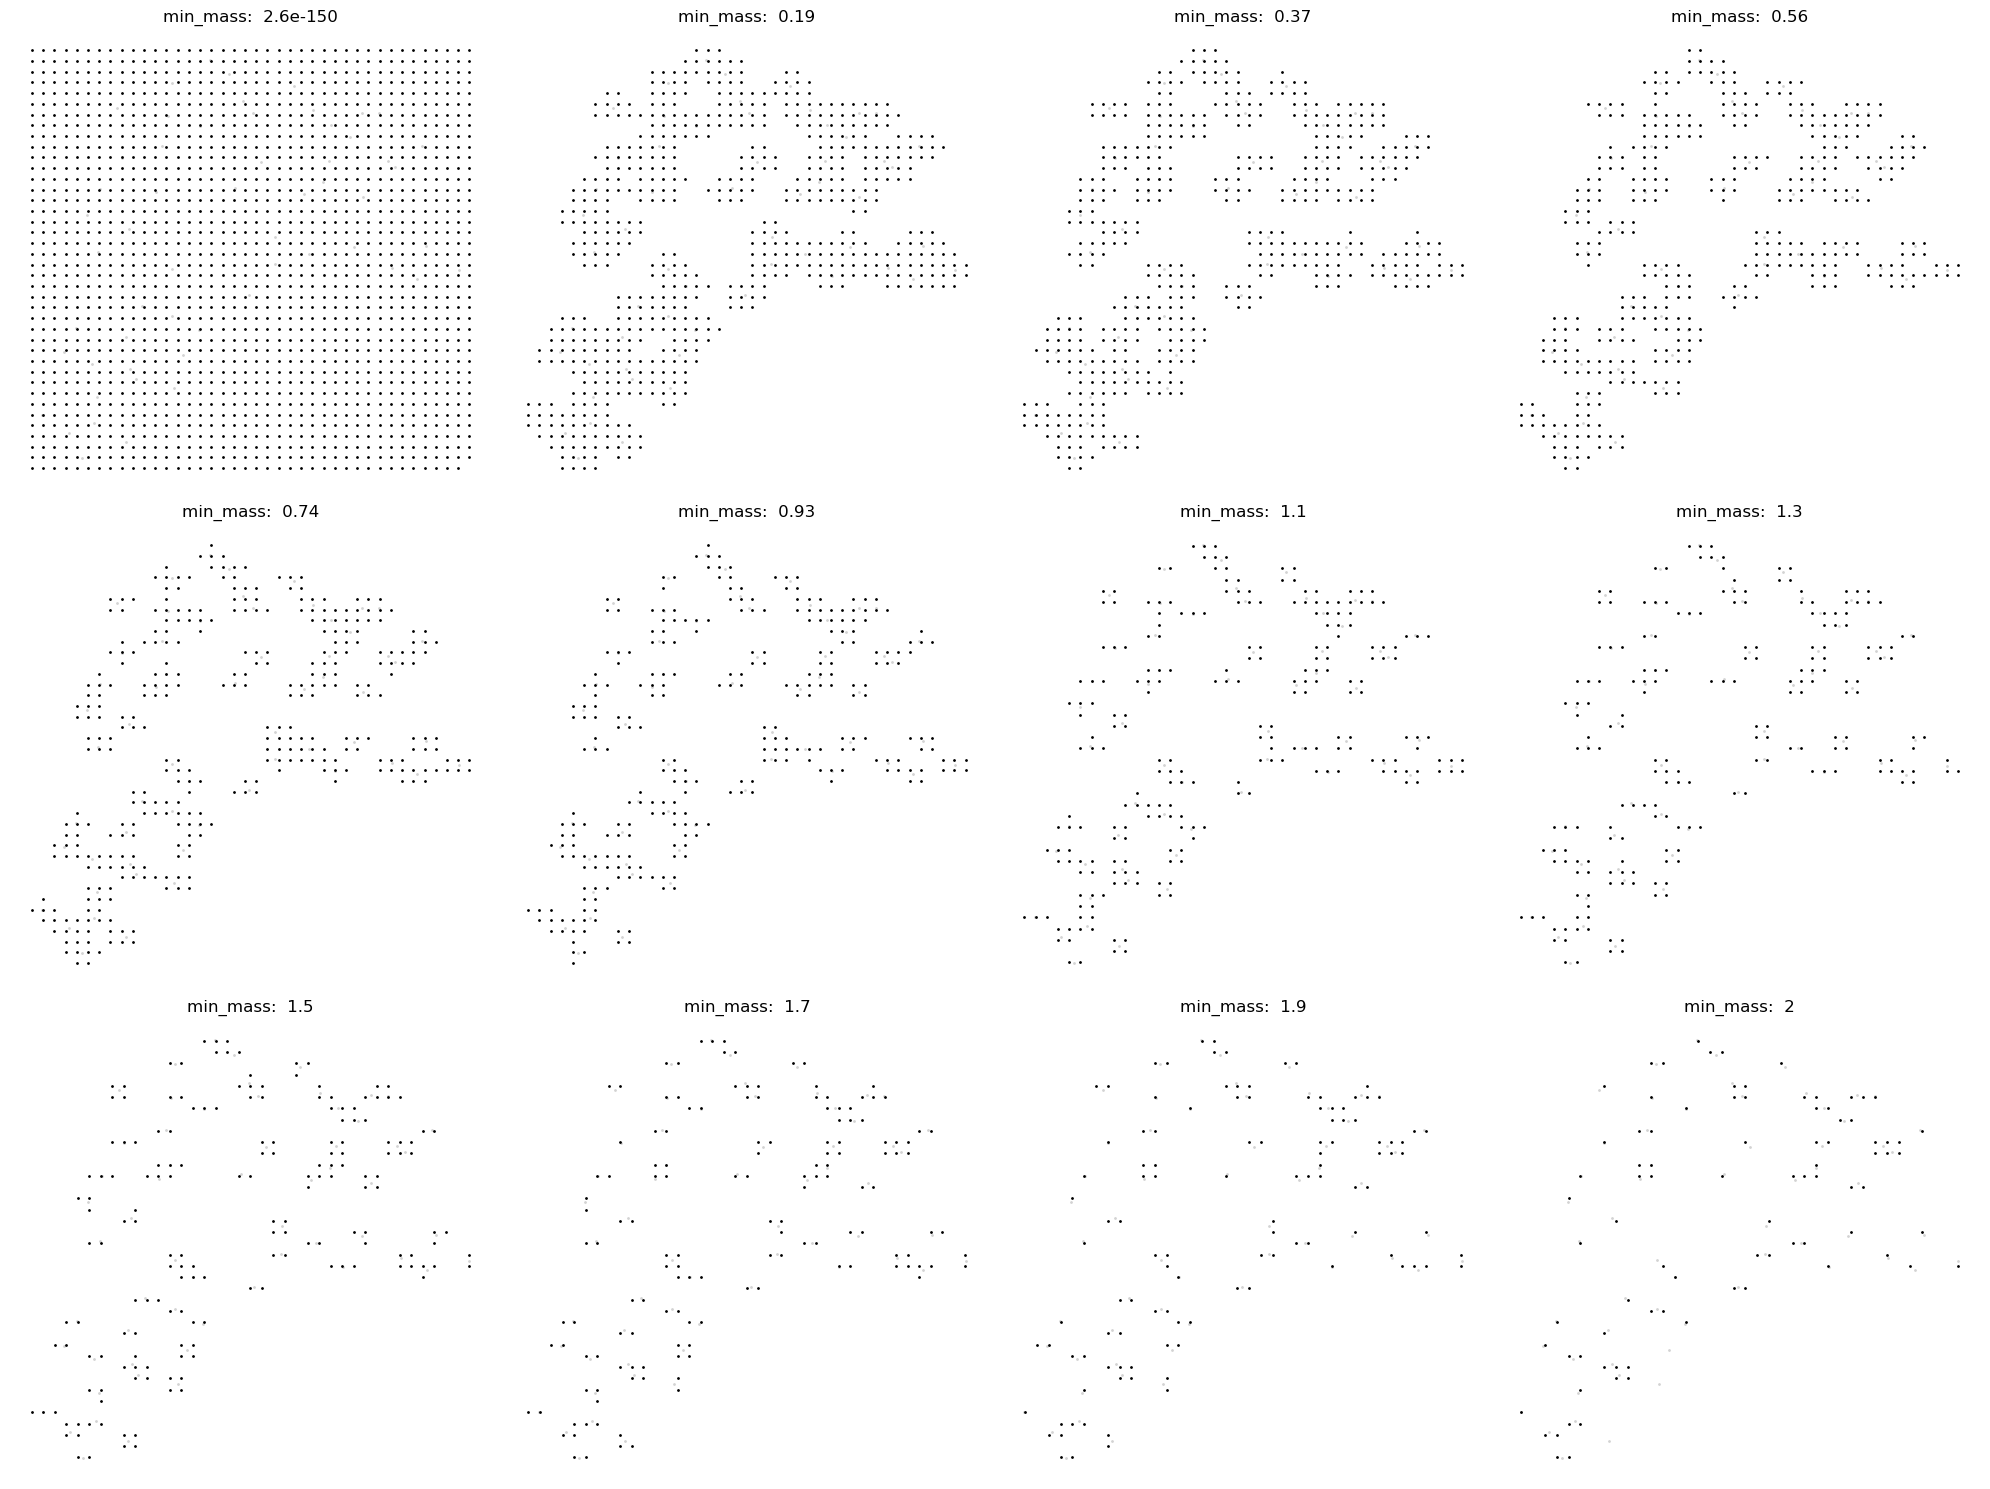

In [223]:
pert_plot_vector_field(adata_TF, adata_down, model_2L, pert_Gene,n_neighbors=None,scale=30,pert_celltype=['Autism'],run_suggest_mass_thresholds=True,fold=fold,state_obs='labels_ori', dot_size=dot_size, min_mass=1.3,embedding_name='X_umap')

In [86]:
dot_size = 800
pert_Gene = ['Faecalibacterium']
fold = [5]

training: 0it [00:00, ?it/s]
training: 0it [00:00, ?it/s]


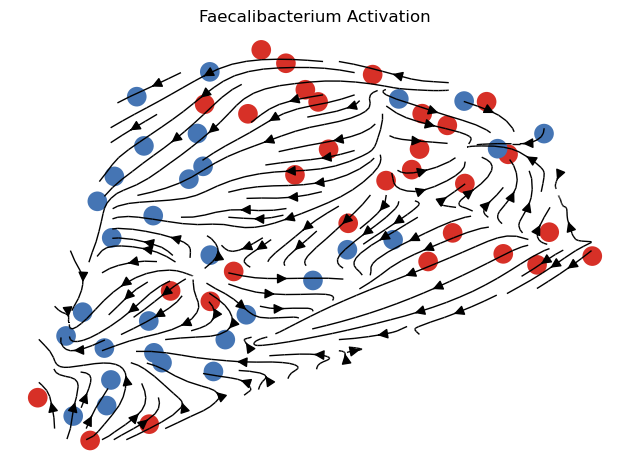

In [87]:
model_output_pert1 = pert_plot_stream(adata_TF, adata_down, model_2L, pert_Gene,n_neighbors=None,scale=30,pert_celltype=['Autism','Control'],run_suggest_mass_thresholds=False,fold=fold,state_obs='labels_ori', dot_size=dot_size, min_mass=1.9,embedding_name='X_umap',palette = {"Autism": "#D73027", "Control": "#4575B4"},save_dir=output_dir)

In [34]:
m2p = model_2L.get_microb_protein_ig().mean(axis=0)

In [30]:
p2y = model_1L.get_up_feature_weights()[0]

In [ ]:
m2p = pd.DataFrame(m2p, index=microb_df.index, columns=X_down.var_names)
m2p.to_csv(os.path.join(output_dir, 'm2p.csv'))

In [49]:
p2y.to_csv(os.path.join(output_dir, 'p2y.csv'))